In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
np.random.seed(0)

In [2]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [26]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus):
    state_next = np.zeros(9+6*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = a_input_noise * np.random.randn(3)                               # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    return state_next

def dynamics_est(dt, state, num_imus):
    print(state.shape)
    state_next = np.zeros((state.shape))
    state_next[:,0:3] = state[:,0:3] + state[:,3:6] * dt        # omega
    state_next[:,3:6] = np.zeros(3)                             # omega_dot
    state_next[:,6:9] = state[:,6:9]                            # specific force
    state_next[:,9:9+6*num_imus] = state[:,9:9+6*num_imus]      # Rate random walk state
    return state_next

In [4]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [5]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        omega = state[0:3]
        omega_dot = state[3:6]
        sf = state[6:9]
        RW_sub = state[9+i*6:15+6*i]
        omega_i = Rb_si_sub @ omega + WN[i*6:i*6+3]*np.random.randn(3) + RW_sub[0:3]
        sf_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*6+3:(i+1)*6]*np.random.randn(3)) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((omega_i, sf_i)) # omega, specific force
    return meas

def measurement_est(state_input, pos_r, Rb_si, num_imus):
    meas = np.zeros((6*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        for i in range(num_imus):
            Rb_si_sub = Rb_si[i]
            r_sub = pos_r[i]
            omega = state[0:3]
            omega_dot = state[3:6]
            sf = state[6:9]
            RW_sub = state[9+6*i:15+6*i]
            omega_i = Rb_si_sub @ omega + RW_sub[0:3]
            sf_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub) + RW_sub[3:6]
            meas[i*6:6+i*6, j] = np.concatenate((omega_i, sf_i)) # omega, specific force
    return meas

In [6]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, pos_r, Rb_si, num_imus):
	alpha = 1.0
	kappa = 1.0
	beta = 1.0

	# Generate 2n+1 sigmaPoints for every state: 
	# one at the mean and 2n for +/- perturbations of each element of the state
	n = len(state)
	sigmaPoints = np.zeros((2*n+1, n))
	sigmaPoints[0] = state
	param_lambda = alpha**2*(n+kappa)-n # lambda is a parameter for pertubing the states
	# delx = np.linalg.cholesky((n+param_lambda)*Cov)
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	for i in range(n):
		sigmaPoints[i+1] = state + delx[i].real
		sigmaPoints[n+i+1] = state - delx[i].real

	print(sigmaPoints)

	# Propagate the sigmaPoints according to discrete time dynamics
	sigmaPoints_prior = dynamics_est(dt, sigmaPoints, num_imus)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	state_prior = w0_m*sigmaPoints_prior[0] + np.sum(wi_mc*sigmaPoints_prior[1:], axis=0)
	diff = sigmaPoints_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(sigmaPoints_prior)):
		diff = sigmaPoints_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	Cov_prior = Cov_prior + R

	# Regenerate sigmaPoints
	delx = np.linalg.cholesky((n+param_lambda)*Cov_prior)
	sigmaPoints_rev = np.zeros((2*n+1, n))
	sigmaPoints_rev[0] = state_prior
	for i in range(n):
		sigmaPoints_rev[i+1] = state + delx[i].real
		sigmaPoints_rev[n+i+1] = state - delx[i].real

	# Predict measurements for each particle
	Y_part = measurement_est(sigmaPoints_rev, pos_r, Rb_si, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
	S = S + Q

	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		sigmaPoints_diff = sigmaPoints_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		sigmaPoints_col = sigmaPoints_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (sigmaPoints_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T

	return state_est, Cov_est

In [7]:
# measurements
measurements = np.array(read_txt("../data/imu.txt"))

In [8]:
num_imus = 3

# randomly generate position arrangement of IMUs
Rb = []
pos = []
for j in range(num_imus):
    pos.append(np.random.rand(3)) # position of jth imu in DISIMU
    Rb.append(np.eye(3)) # orientation of jth imu in DISIMU
pos_r = np.asarray(pos)
Rb_si = np.asarray(Rb)
w_input_noise = 1e-5
a_input_noise = 1e-5

# parameters from datasheet
gyroscope_wn = 0.002 # degrees / s / sqrt(Hz)
accelerometer_wn = 0.016 # m / s^2 / sqrt(Hz)
gyroscope_arw = 0.09 # degrees / sqrt(Hr)
accelerometer_vrw = 0.008 # m / s / sqrt(Hr)
WN = np.hstack((gyroscope_wn*np.ones(3*num_imus), accelerometer_wn*np.ones(3*num_imus)))
RW = np.hstack((gyroscope_arw*np.ones(3*num_imus), accelerometer_vrw*np.ones(3*num_imus)))

dt = 1e-2
time = np.arange(0, 360, dt)

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9 + 6*num_imus)
state_est = np.zeros(9 + 6*num_imus)
omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 10]) # assuming 10 m/s^2 for gravity
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9 + 6*num_imus))
state_est_hist = np.zeros((len(time), 9 + 6*num_imus))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Covariance of dynamics
R = np.zeros((9 + 6*num_imus, 9 + 6*num_imus))
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:9,6:9] = a_input_noise ** 2 * np.eye(3)
R[9:9+6*num_imus, 9:9+6*num_imus] = np.diag(RW**2)

Q = np.diag(WN**2)
Cov_est = 1e-4*np.eye(9+6*num_imus)

for i in trange(len(time)):
    state_hist[i] = state
    state = dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus)
    meas = measurements[i]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, pos_r, Rb_si, num_imus)
    state_est_hist[i] = state_est


100%|██████████| 36000/36000 [09:18<00:00, 64.43it/s] 


## Allan Variance Visualization

DISIMU omega hat: quantization    0.000000
white           0.351949
flicker         1.185284
walk            0.873637
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000000
white           0.239016
flicker         0.817550
walk            1.062730
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000000
white           0.445829
flicker         0.511359
walk            0.996671
ramp            0.000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

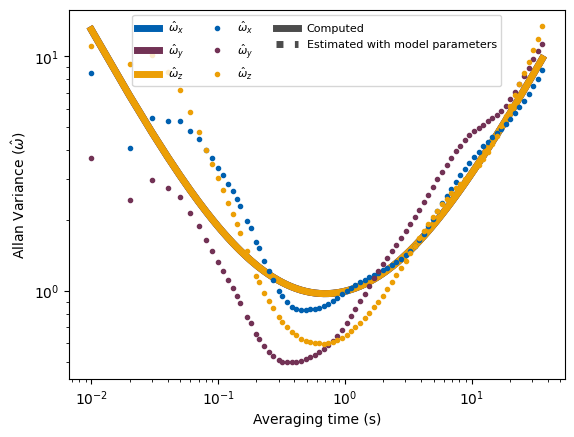

In [9]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wx, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wx, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.000000
white           0.000000
flicker         0.065047
walk            0.850606
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000090
white           0.003243
flicker         0.000000
walk            0.913487
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000129
white           0.000000
flicker         0.046962
walk            0.878522
ramp            0.102423
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.000000
white           0.000000
flicker         0.070913
walk            0.832159
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000128
white           0.002240
flicker         0.030574
walk            0.895887
ramp            0.019700
Name: 0, dtype: float64, quantization    0.000207
white           0.000000
flicker         0.000000
walk            0.922562
ramp            0.000000
Name: 0, dtype: float64
IMU 3 SF hat: quantization    0.000145
white           0.000000
flicker   

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

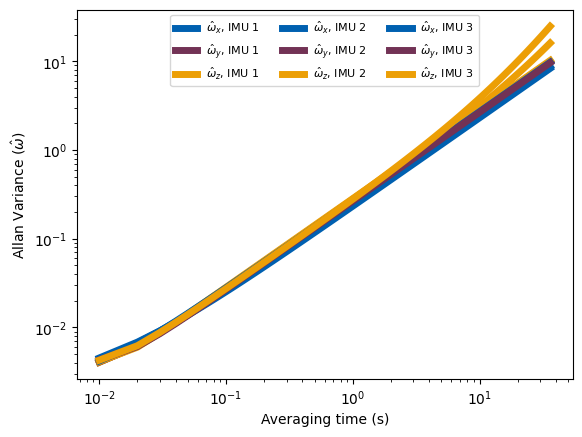

In [10]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

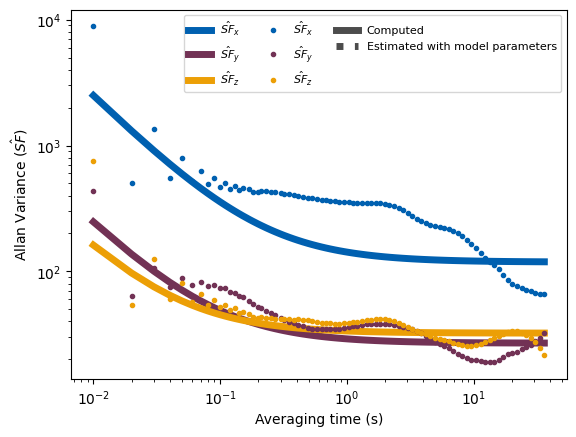

In [11]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.000015
white           0.000000
flicker         0.004555
walk            0.078208
ramp            0.004488
Name: 0, dtype: float64, quantization    0.000000
white           0.000388
flicker         0.000000
walk            0.079516
ramp            0.011338
Name: 0, dtype: float64, quantization    0.000021
white           0.000000
flicker         0.000000
walk            0.081794
ramp            0.002309
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.000069
white           0.000972
flicker         0.009238
walk            0.077341
ramp            0.005018
Name: 0, dtype: float64, quantization    0.000030
white           0.001567
flicker         0.000000
walk            0.080551
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000077
white           0.000000
flicker         0.014241
walk            0.070072
ramp            0.000000
Name: 0, dtype: float64/n
IMU 3 SF hat: quantization    0.000017
white           0.001602
flicke

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

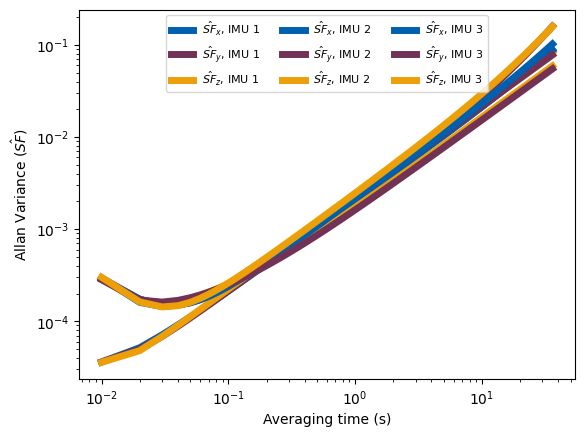

In [12]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0, 0.5, '$\\hat{\\omega}$ (rad/s)')

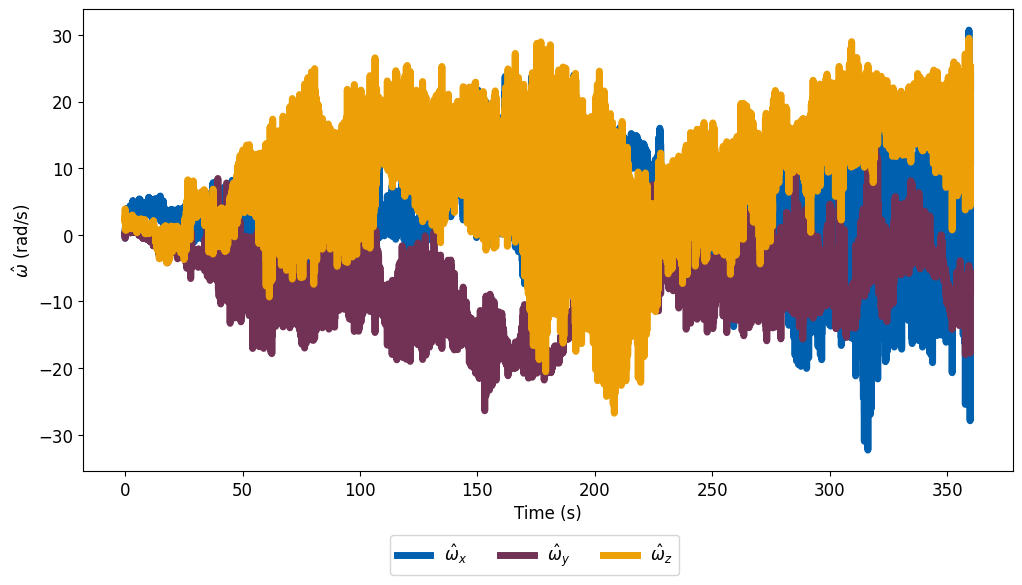

In [13]:
# single IMU, omega hat
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.5, 2])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ (rad/s)", fontsize=12)

Text(0, 0.5, '$\\omega$ (rad/s)')

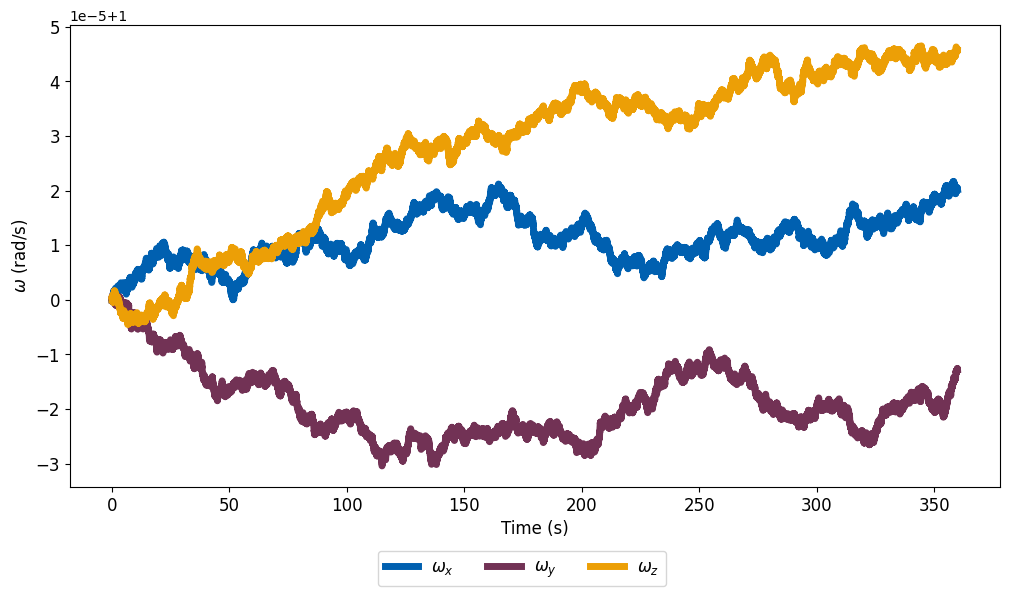

In [14]:
# omega
fig2, ax2 = plt.subplots(figsize = (12, 6))
ax2.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax2.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax2.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax2.set_xlabel("Time (s)", fontsize=12)
# ax2.set_ylim([-0.005, 0.005]) # using same units as above
ax2.set_ylabel("$\omega$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

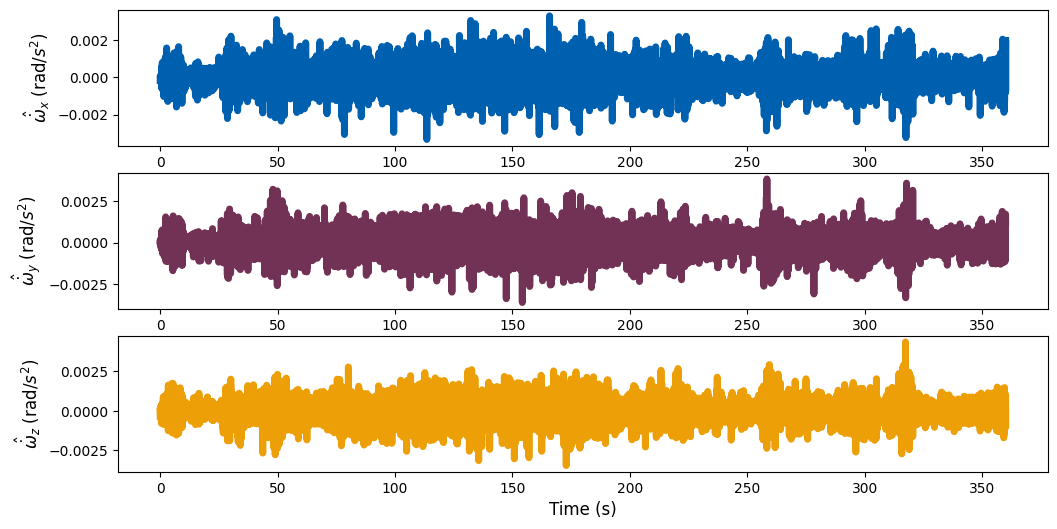

In [15]:
# fused omega hat dot
fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax3[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax3[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
# ax3[0].set_ylim([-0.1, 0.1])
# ax3[1].set_ylim([-0.1, 0.1])
# ax3[2].set_ylim([-0.1, 0.1])
ax3[0].set_ylabel("$\hat{\dot{\omega}}_x$ (rad/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{\dot{\omega}}_y$ (rad/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{\dot{\omega}}_z$ (rad/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0, 0.5, '$\\dot{\\omega}$ (rad/s)')

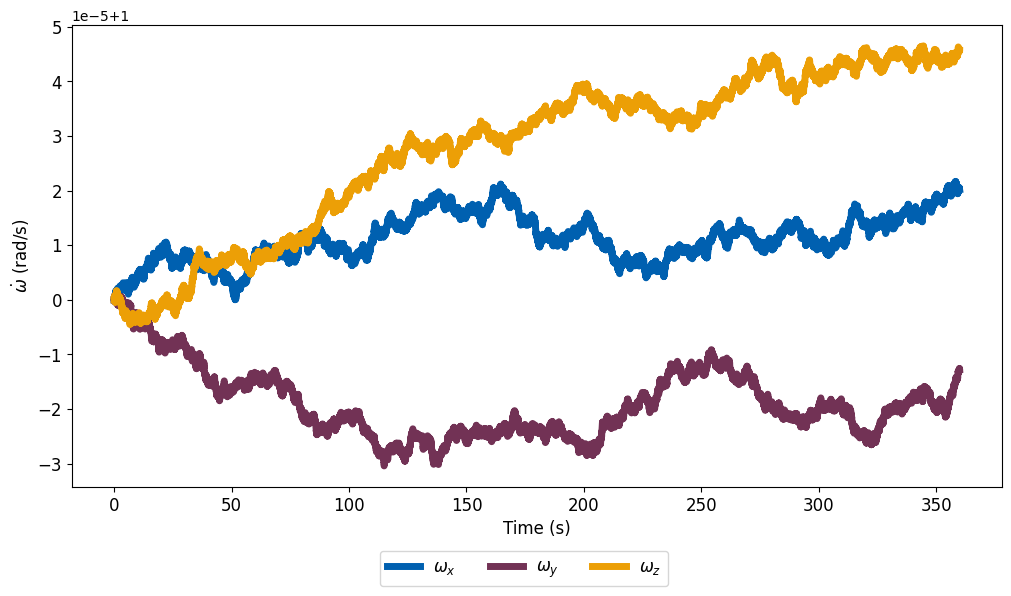

In [16]:
# dynamics, omega dot
fig4, ax4 = plt.subplots(figsize = (12, 6))
ax4.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax4.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax4.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax4.set_xlabel("Time (s)", fontsize=12)
# ax4.set_ylim([-0.005, 0.005]) # using same units as above
ax4.set_ylabel("$\dot{\omega}$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

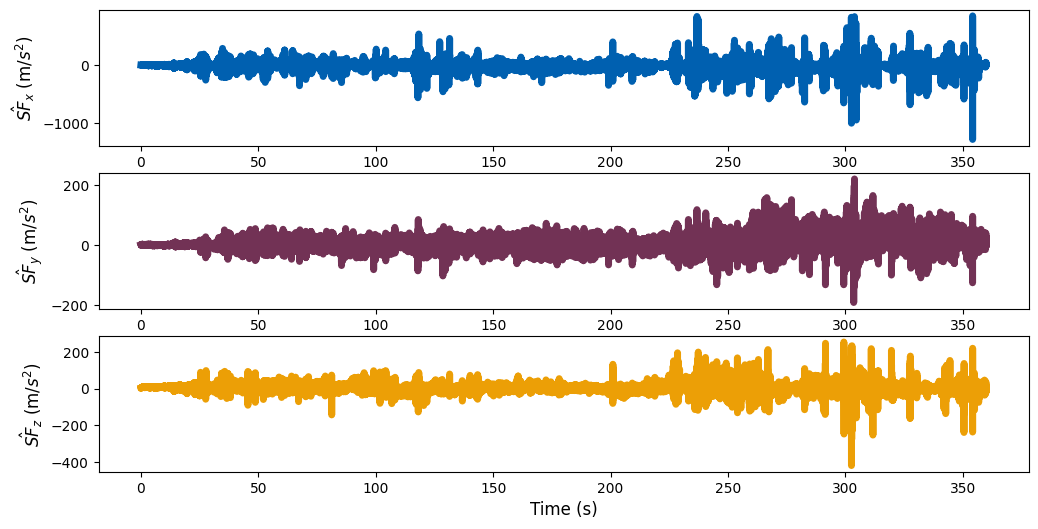

In [17]:
# system, SF hat
fig5, ax5 = plt.subplots(3, 1, figsize = (12, 6))
ax5[0].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax5[1].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax5[2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
# ax5[0].set_ylim([-0.1, 0.1])
# ax5[1].set_ylim([-0.1, 0.1])
# ax5[2].set_ylim([-0.1, 0.1])
ax5[0].set_ylabel("$\hat{SF}_x$ (m/$s^2$)", fontsize=12)
ax5[1].set_ylabel("$\hat{SF}_y$ (m/$s^2$)", fontsize=12)
ax5[2].set_ylabel("$\hat{SF}_z$ (m/$s^2$)", fontsize=12)
ax5[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

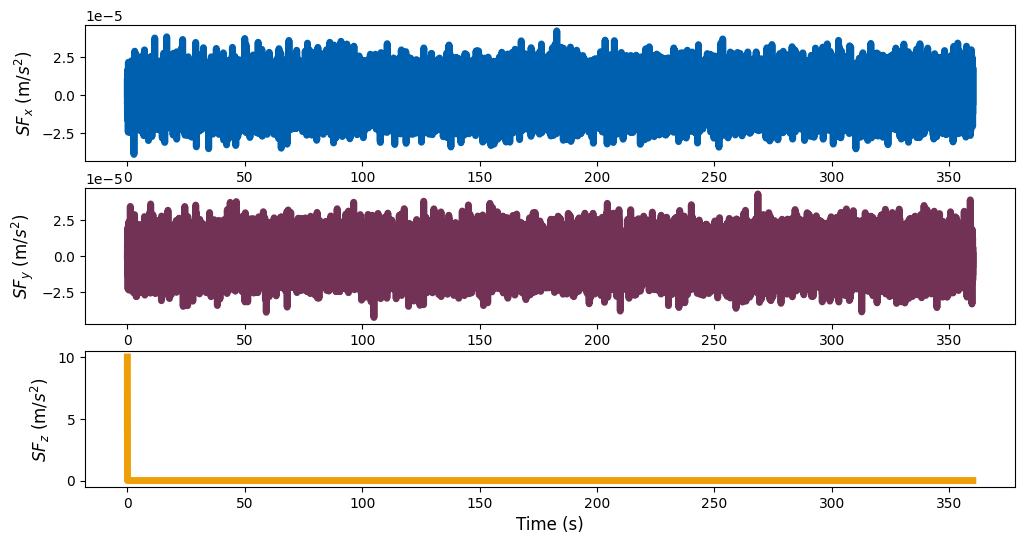

In [25]:
# dynamics, SF
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,6])
# plt.plot(time, state_hist[:,7])
# plt.plot(time, state_hist[:,8])
# plt.title("specific force")

fig6, ax6 = plt.subplots(3, 1, figsize = (12, 6))
ax6[0].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$SF_x$")
ax6[1].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$SF_y$")
ax6[2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$SF_z$")
# ax3[0].set_ylim([-0.0025, 0.0025])
# ax3[1].set_ylim([-0.0025, 0.0025])
# ax3[2].set_ylim([-0.0025, 0.0025])
# ax6[0].set_ylim([-0.005, 0.005])
# ax6[1].set_ylim([-0.005, 0.005])
# ax6[2].set_ylim([-0.005, 0.005])
ax6[0].set_ylabel("$SF_x$ (m/$s^2$)", fontsize=12)
ax6[1].set_ylabel("$SF_y$ (m/$s^2$)", fontsize=12)
ax6[2].set_ylabel("$SF_z$ (m/$s^2$)", fontsize=12)
ax6[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

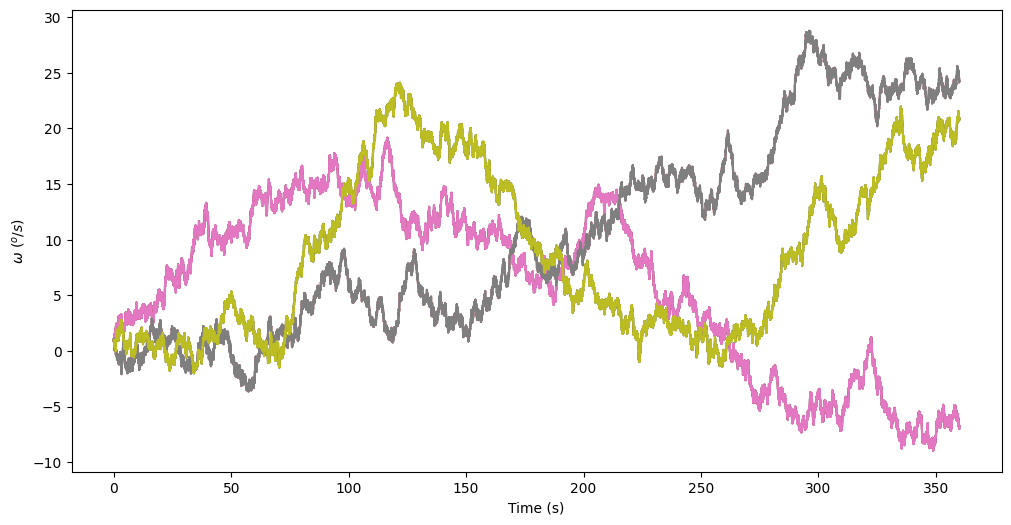

In [19]:
plt.figure(figsize = (12, 6))
for jth in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

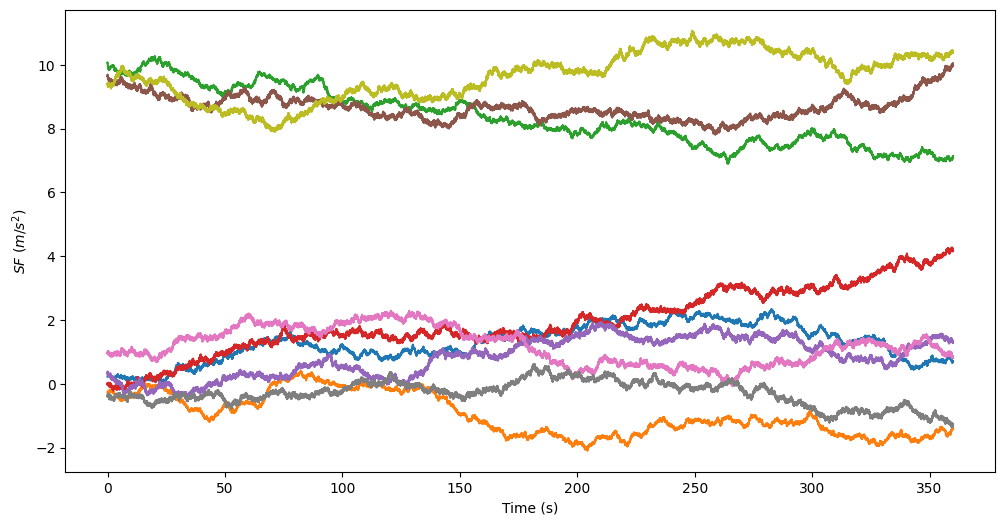

In [20]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")

Text(0.5, 1.0, 'RW')

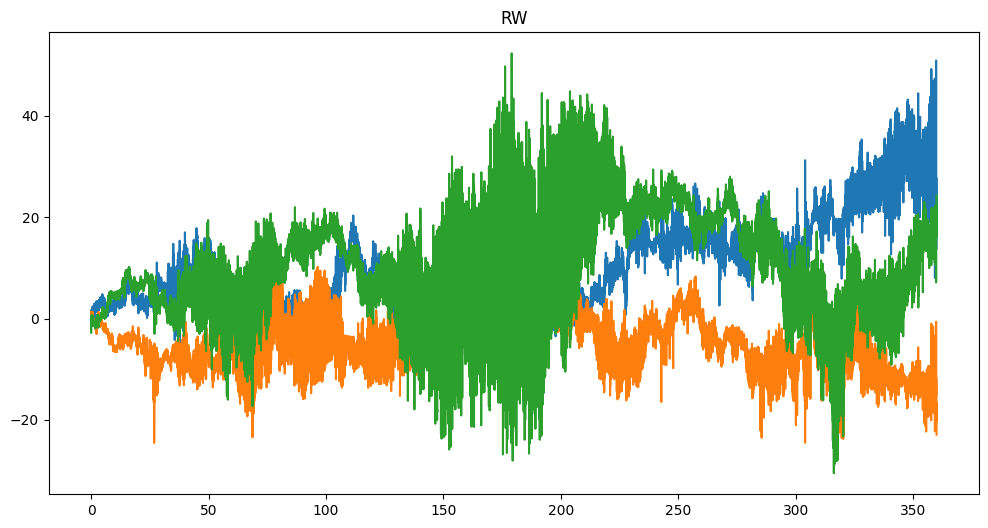

In [21]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,9])
plt.plot(time, state_est_hist[:,10])
plt.plot(time, state_est_hist[:,11])
plt.title("RW")

Text(0.5, 1.0, 'RW')

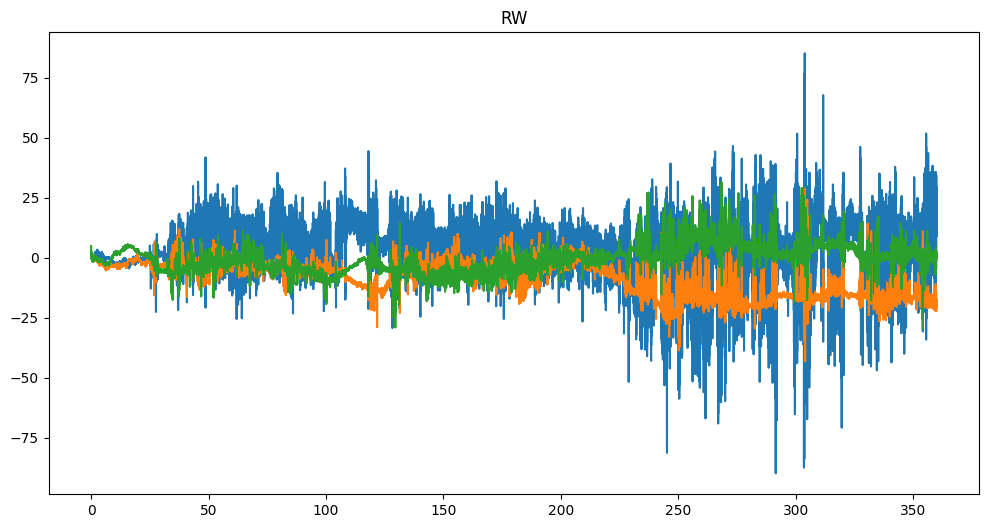

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,12])
plt.plot(time, state_est_hist[:,13])
plt.plot(time, state_est_hist[:,14])
plt.title("RW")

Text(0.5, 1.0, 'RW')

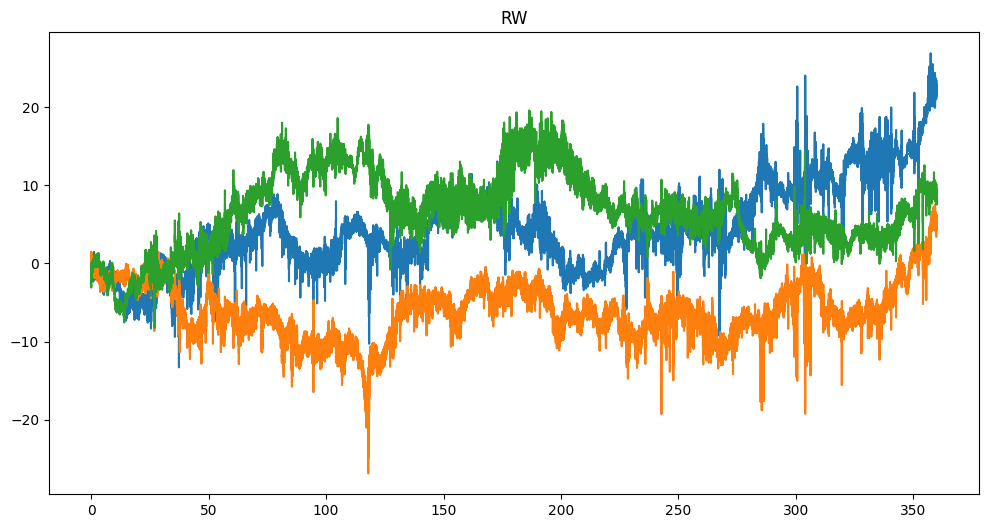

In [23]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,15])
plt.plot(time, state_est_hist[:,16])
plt.plot(time, state_est_hist[:,17])
plt.title("RW")

Text(0.5, 1.0, 'GM')

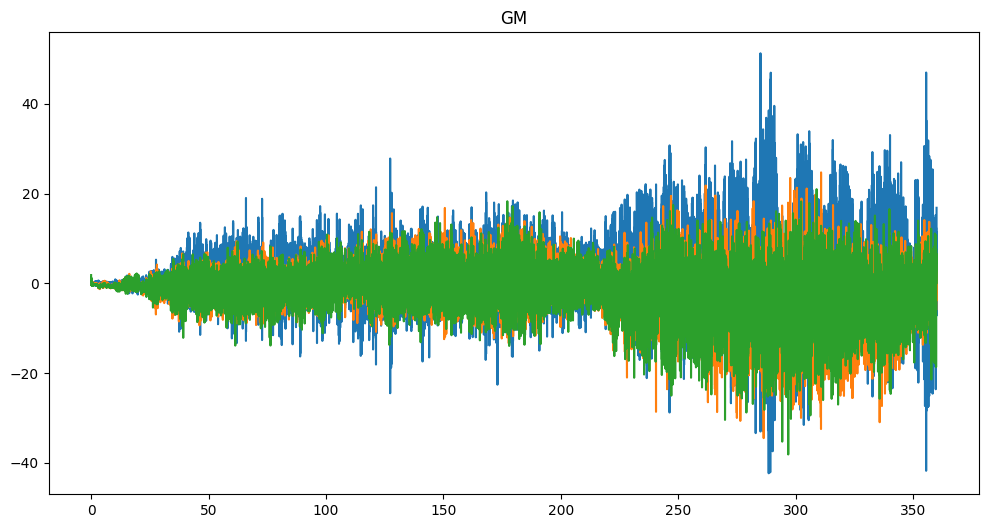

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,18])
plt.plot(time, state_est_hist[:,19])
plt.plot(time, state_est_hist[:,20])
plt.title("GM")